<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebook/HLP_1_sounds_clf_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np

from IPython.display import Audio
import librosa
import librosa.display

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.utils import np_utils

from google.colab import drive
drive.mount('/content/drive/')

path = 'drive/MyDrive/MyProject/audio_classification/'

Mounted at /content/drive/


In [ ]:
!ls drive/MyDrive/MyProject/audio_classification/pass

In [ ]:
file = path + 'pass/7533_tw_Pass_35.wav'
Audio(file)

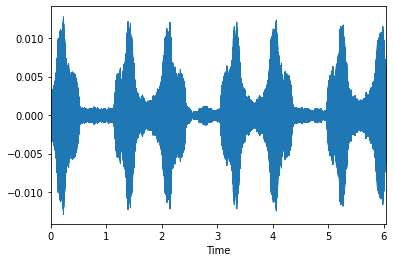

In [ ]:
y1, _ = librosa.load(file, sr=8000) # 把第一段音訊的wav檔讀進來
librosa.display.waveplot(y1, sr=8000) # 把第一段音訊畫出來

In [ ]:
y1.shape

(48299,)

In [ ]:
def readfiles():
  path = 'drive/MyDrive/MyProject/audio_classification/'
  pos = path + '/pass/'
  neg = path  + '/leak/'
  count_p, count_n = 0, 0
  pn = len([name for name in os.listdir(pos)]) 
  nn = len([name for name in os.listdir(neg)]) 
  data = np.zeros([(pn+nn)*2, 17000])
  label = np.zeros([(pn+nn)*2])

  for i in os.listdir(pos):
    y1, _ = librosa.load(pos + i, sr=8000) 

    y1 = y1[0:17000]
    data[count_p] = y1
    label[count_p] = 1
    count_p +=1

    y1 = y1[-17000:]
    data[count_p] = y1
    label[count_p] = 1
    count_p +=1
  for i in os.listdir(neg):
    y1, _ = librosa.load(neg + i, sr=8000) 

    y1 = y1[0:17000]
    data[count_p + count_n] = y1
    label[count_p+count_n] = 0
    count_n +=1

    y1 = y1[-17000:]
    data[count_p + count_n] = y1
    label[count_p+count_n] = 0
    count_n +=1

  return label, data, (pn+nn)*2

if os.path.exists(path + "data/data_l.npy"):
  print('data existed!')
  l = np.load(path + 'data/data_l.npy')
  d = np.load(path + 'data/data_d.npy')
  n = np.load(path + 'data/data_n.npy')
else:  
  l, d, n = readfiles()
  np.save(path + 'data/data_l', l)
  np.save(path + 'data/data_d', d)
  np.save(path + 'data/data_n', n)


In [ ]:
l = l.reshape(n, 1)
d = d.reshape(n, 17000, 1)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(d, l, test_size = 0.3, random_state = 43)

In [ ]:
print('\n', train_x.shape, '\n', test_x.shape, '\n', train_y.shape, '\n', test_y.shape)

In [ ]:
train_y = np_utils.to_categorical(train_y, 2)
test_y = np_utils.to_categorical(test_y, 2)

In [ ]:
print(train_y[:,0].sum()) #275
print(train_y[:,1].sum()) #280
print(test_y[:,0].sum()) #275
print(test_y[:,1].sum()) #114

In [ ]:
model = Sequential()
model.add(Conv1D(200, 100, strides = 1, input_shape=(17000,1)))
model.add(BatchNormalization()) 
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(200, 100,strides = 1))
model.add(BatchNormalization()) 
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(200, 100, strides = 1))
model.add(BatchNormalization()) 
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(200, 100, strides = 1))
model.add(BatchNormalization()) 
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))


model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()


In [ ]:
model.load_weights(path + 'logs0526/' + 'model.11-1.10.h5')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.evaluate(test_x, test_y)



In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs =100, validation_split= 0.2 , batch_size= 32, verbose = 1)

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs =50, validation_split= 0.2 , batch_size= 32, verbose = 1)


log_dir = path + 'logs0527_PR/'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=25),
    tf.keras.callbacks.ModelCheckpoint(filepath=log_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
]
#model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
# 這一行是跑完 logs0527_PR 之後才 remove 掉，因為觀察到重下 compile，val_loss 有點跳太大，可能是 learning rate 重設了？？？？
# 不過在 logs0527 (patience = 20) 採用 epochs (250, 50, 300) 似乎沒有這個現象
history = model.fit(train_x, train_y, epochs =300, validation_split= 0.2 , batch_size= 32, verbose = 1, callbacks=my_callbacks)
model.evaluate(test_x, test_y)



In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
model.load_weights(path + 'logs0527_PR/' + 'model.01-0.93.h5')
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
model.evaluate(test_x, test_y)


In [ ]:
'''
model.evaluate(test_x, test_y)
model.save(path + '08828_save.h5')
model.save_weights(path + '08828_save_weights.h5')
'''

In [ ]:
'''
model.save(path + '08536_save.h5')
model.save_weights(path + '08536_save_weights.h5')

model.evaluate(test_x, test_y)
'''

In [ ]:
import matplotlib.pyplot as plt

def show_train_progress(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    #plt.legend(['train','validation'],loc='upper left')
    plt.legend(['train','validation'],loc=2)
    
    plt.show()
show_train_progress(history,'accuracy','val_accuracy')    

In [ ]:
scores = model.evaluate(test_x, test_y)

In [ ]:
test_y[:,0].astype('int')
prediction = model.predict_classes(test_x)
print(prediction)
print(test_y[:,1].astype('int'))

In [ ]:
train_x.shape

# if spectrogram

In [ ]:
'''
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('path-to-mono-audio-file.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel
'''